In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

In [2]:
train_df = pd.read_excel("data\\train.xlsx")
test_df = pd.read_excel("data\\test.xlsx")
merged_df = pd.concat([train_df, test_df], axis=0)
merged_df.to_csv("merged_df.csv", index=False)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


## Создание модели без дополнительных признаков

0:	learn: 9397.2900004	test: 8778.4285720	best: 8778.4285720 (0)	total: 724us	remaining: 1.09s
100:	learn: 4965.2649923	test: 1883.1783745	best: 1883.1783745 (100)	total: 41.8ms	remaining: 579ms
200:	learn: 2873.9457963	test: 1696.9997260	best: 1653.7972553 (198)	total: 89.9ms	remaining: 581ms
300:	learn: 1988.3389720	test: 1603.2915298	best: 1603.2915298 (300)	total: 142ms	remaining: 565ms
400:	learn: 1563.7553541	test: 1552.1126744	best: 1548.9394887 (396)	total: 194ms	remaining: 532ms
500:	learn: 1325.5803596	test: 1459.2902990	best: 1459.2902990 (500)	total: 247ms	remaining: 493ms
600:	learn: 1172.3365715	test: 1366.6392486	best: 1366.6392486 (600)	total: 301ms	remaining: 451ms
700:	learn: 1007.3787827	test: 1234.1992892	best: 1234.1992892 (700)	total: 349ms	remaining: 398ms
800:	learn: 899.9221230	test: 1168.8496016	best: 1168.8496016 (800)	total: 397ms	remaining: 346ms
900:	learn: 795.9169866	test: 1110.0752494	best: 1110.0752494 (900)	total: 441ms	remaining: 293ms
1000:	learn: 7

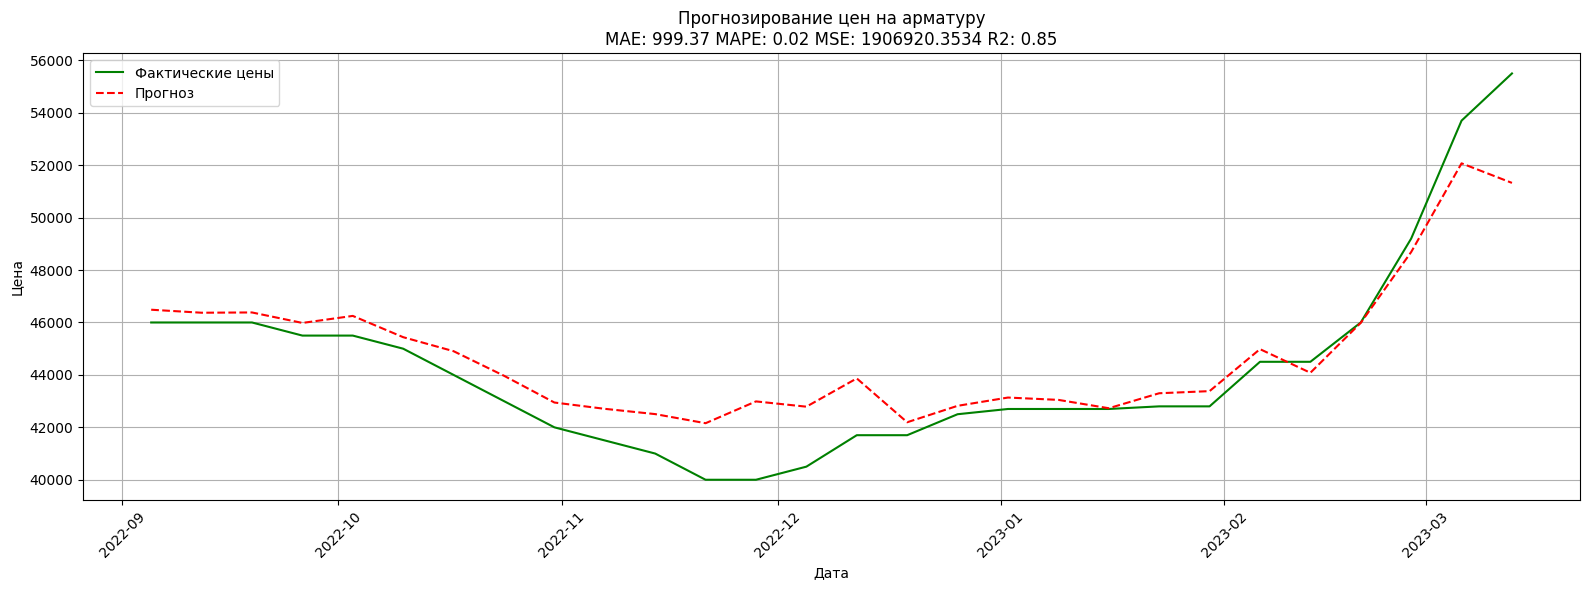

            feature  importance
0             lag_1   48.442203
1             lag_2   24.928218
5   rolling_mean_12    7.013946
2             lag_4    6.021426
7              year    5.064145
3            lag_12    2.891133
12        Цена_diff    2.105805
6    rolling_std_12    1.270317
4            lag_52    0.948161
8             month    0.817980


In [36]:
def create_features(df):
    # Лаги
    for lag in [1, 2, 4, 12, 52]:
        df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    # Скользящие статистики
    df['rolling_mean_12'] = df['Цена на арматуру'].shift(1).rolling(12).mean()
    df['rolling_std_12'] = df['Цена на арматуру'].shift(1).rolling(12).std()
    # Создание временных признаков
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week'] = df['dt'].dt.isocalendar().week
    # Циклические признаки
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # Дифференцирование
    df['Цена_diff'] = df['Цена на арматуру'].diff()
    df = df.sort_values('dt').set_index('dt')
    return df

merged_mod_df = create_features(merged_df.copy())
# 1. Убедимся, что целевая переменная исключена из признаков
features = [col for col in merged_mod_df.columns 
            if col not in ['Цена на арматуру']]

# 2. Корректное разделение данных с защитой от утечки
test_start_date = test_df['dt'].min()
train = merged_mod_df[merged_mod_df.index < test_start_date]
test = merged_mod_df[merged_mod_df.index >= test_start_date]



# 4. Корректное разделение на фичи и таргет
X_train = train[features]
y_train = train['Цена на арматуру']
X_test = test[features]
y_test = test['Цена на арматуру']

# 5. Настройка CatBoost с временной валидацией
tscv = TimeSeriesSplit(n_splits=5)
best_params = { 'depth': 2,
                'iterations': 1500,
                'loss_function': 'MAE',
                'verbose': 100,
                'l2_leaf_reg': 3,
                'learning_rate': 0.01
}
model = CatBoostRegressor(**best_params, grow_policy='Lossguide', bootstrap_type='Bayesian', has_time=True)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True)

# 6. Прогнозирование и оценка
y_pred = model.predict(X_test)
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогнозирование цен на арматуру\nMAE: {mean_absolute_error(y_test, y_pred):.2f} MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f} MSE: {mean_squared_error(y_test, y_pred):.4f} R2: {r2_score(y_test, y_pred):.2f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
model.save_model('catboostmodel_artem.cbm')
print(feature_importance.head(10))

# Создание модели с дополнительными признаками

## Начало очистки данных

In [5]:
def clean_action_data(df):

    # Обработка объема
    def convert_volume(x):
        if isinstance(x, str):
            x = x.replace(',', '.')
            if 'K' in x:
                return float(x.replace('K', '')) * 1_000
            if 'M' in x:
                return float(x.replace('M', '')) * 1_000_000
        return float(x)
    
    
    df['Vol.'] = df['Vol.'].astype(str).apply(convert_volume)
    
    # Обработка процентов
    df['Change %'] = df['Change %'].str.replace('%', '', regex=False).str.replace(',', '.').astype(float) / 100
    
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

def aggregate_weekly(df):
    """
    Агрегирует данные по неделям (начиная с понедельника).

    Параметры:
    df (pd.DataFrame): Датафрейм с данными об акциях. Должен содержать столбец 'Date'.

    Возвращает:
    pd.DataFrame: Датафрейм, агрегированный по неделям.
    """
    df = df.copy()  # Создаем копию, чтобы не изменять оригинальный датафрейм
    
    # Приводим столбец 'Date' к формату datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    
    # Устанавливаем дату как индекс
    df.set_index('Date', inplace=True)
    
    # Группируем по неделям (неделя заканчивается в понедельник)
    weekly_df = df.resample('W-MON').agg({
        'Price': 'mean',    # Средняя цена за неделю
        'Open': 'first',    # Цена открытия первой даты недели
        'High': 'max',      # Максимальное значение недели
        'Low': 'min',       # Минимальное значение недели
        'Vol.': 'sum',      # Суммарный объём за неделю
        'Change %': 'last'  # Последнее значение процента изменения
    })

    # Сброс индекса для возврата 'Date' в качестве столбца
    return weekly_df.reset_index()


chmf_df = pd.read_csv("data\\CHMF Акции.csv")
magn_df = pd.read_csv("data\\MAGN Акции.csv")
nlmk_df = pd.read_csv("data\\NLMK Акции.csv")
lme_index_df = pd.read_excel("data\\Индекс LME.xlsx")
metal_market_df = pd.read_excel("data\\Показатели рынка металла.xlsx")
transportation_df = pd.read_excel("data\\Грузоперевозки.xlsx")
fuel_df = pd.read_excel("data\\Топливо.xlsx")
material_prices_df = pd.read_excel("data\\Цены на сырье.xlsx")
macro_df = pd.read_excel("data\\Макропоказатели.xlsx")

for dframe in (chmf_df, magn_df, nlmk_df, lme_index_df, metal_market_df, transportation_df, fuel_df, material_prices_df):
    dframe.info()
    print("--------------------------------------------------------//////////////////////////////////////")



numeric_cols = ['Price', 'Open', 'High', 'Low']

for col in numeric_cols:
        chmf_df[col] = chmf_df[col].str.replace(',', '').astype(float)

magn_df = magn_df.rename(columns={
        "Дата": "Date",
        "Цена": "Price",
        "Откр.": "Open",
        "Макс.": "High",
        "Мин.": "Low",
        "Объём": "Vol.",
        "Изм. %": "Change %"
})

magn_df["Date"] = pd.to_datetime(magn_df['Date'], format='%d.%m.%Y')

for col in numeric_cols:
        magn_df[col] = magn_df[col].str.replace(',', '.').astype(float)

for dframe in (chmf_df, magn_df, nlmk_df):
        clean_action_data(dframe)
        print(dframe.head())
        print(dframe.dtypes)
        print("\n-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-\n")



chmf_df = aggregate_weekly(chmf_df)
magn_df = aggregate_weekly(magn_df)
nlmk_df = aggregate_weekly(nlmk_df)
chmf_df.to_excel("CHMF Акции_mod.xlsx", index=False)
magn_df.to_excel("MAGN Акции_mod.xlsx", index=False)
nlmk_df.to_excel("NLMK Акции_mod.xlsx", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1054 non-null   object
 1   Price     1054 non-null   object
 2   Open      1054 non-null   object
 3   High      1054 non-null   object
 4   Low       1054 non-null   object
 5   Vol.      1053 non-null   object
 6   Change %  1054 non-null   object
dtypes: object(7)
memory usage: 57.8+ KB
--------------------------------------------------------//////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Дата    1053 non-null   object
 1   Цена    1053 non-null   object
 2   Откр.   1053 non-null   object
 3   Макс.   1053 non-null   object
 4   Мин.    1053 non-null   object
 5   Объём   1053 non-null   object
 6   Изм. %  1053 non-

In [6]:
lme_index_df = lme_index_df.dropna()
lme_index_df['цена'] = lme_index_df['цена'].astype(float)
lme_index_df = lme_index_df.rename(columns={"дата": "dt", "цена": "lme_index"})
# Устанавливаем 'dt' как индекс
lme_index_df.set_index('dt', inplace=True)

# Ресэмплинг: создаем новую временную шкалу - каждую неделю по понедельникам.
# Здесь мы используем asfreq(), чтобы установить новые даты, а затем заполним недостающие значения.
weekly_df = lme_index_df.resample('W-MON').asfreq()

# Заполним недостающие значения методом линейной интерполяции
weekly_df = weekly_df.interpolate(method='linear')

weekly_df = weekly_df.reset_index()
lme_index_df = weekly_df
lme_index_df.to_excel("Индекс LME_mod.xlsx", index=False)

lme_index_df.info()

# Устанавливаем 'dt' как индекс
metal_market_df.set_index('dt', inplace=True)

# Создаем новый недельный индекс, где каждая дата — понедельник
weekly_index = pd.date_range(start=metal_market_df.index.min(), end=metal_market_df.index.max(), freq='W-MON')

# Реиндексируем таблицу, используя forward-fill для заполнения пропусков
weekly_df = metal_market_df.reindex(weekly_index, method='ffill')

# Сбрасываем индекс, чтобы 'dt' снова стал обычным столбцом
metal_market_df = weekly_df.reset_index().rename(columns={'index': 'dt'})
metal_market_df.to_excel("Показатели рынка металла_mod.xlsx", index=False)
metal_market_df.info()

# Устанавливаем 'dt' как индекс
transportation_df.set_index('dt', inplace=True)

# Ресэмплинг: создаем новую временную шкалу - каждую неделю по понедельникам.
weekly_df = transportation_df.resample('W-MON').last().ffill()

weekly_df = weekly_df.reset_index().dropna()
transportation_df = weekly_df
transportation_df.to_excel("Грузоперевозки_mod.xlsx", index=False)
transportation_df.info

# Устанавливаем 'dt' как индекс
fuel_df.set_index('dt', inplace=True)

# Ресэмплинг: создаем новую временную шкалу - каждую неделю по понедельникам.
# Здесь мы используем asfreq(), чтобы установить новые даты, а затем заполним недостающие значения.
weekly_df = fuel_df.resample('W-MON').asfreq()

# Заполним недостающие значения методом линейной интерполяции
weekly_df = weekly_df.interpolate(method='linear')

weekly_df = weekly_df.reset_index().dropna()
fuel_df = weekly_df
fuel_df.to_excel("Топливо_mod.xlsx", index=False)
fuel_df.info()

# Устанавливаем столбец 'dt' как индекс
macro_df.set_index('dt', inplace=True)

# Создаем новый недельный индекс, где каждая дата — понедельник
weekly_index = pd.date_range(start=macro_df.index.min(), end=macro_df.index.max(), freq='W-MON')

# Реиндексируем таблицу, используя forward-fill для заполнения пропусков
macro_weekly = macro_df.reindex(weekly_index, method='ffill')

# Сбрасываем индекс, чтобы 'dt' снова стал обычным столбцом
macro_df = macro_weekly.reset_index().rename(columns={'index': 'dt'})
macro_df.to_excel("Макропоказатели_mod.xlsx", index=False)
macro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dt         111 non-null    datetime64[ns]
 1   lme_index  111 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 81 columns):
 #   Column                                                                 Non-Null Count  Dtype         
---  ------                                                                 --------------  -----         
 0   dt                                                                     365 non-null    datetime64[ns]
 1   Производство арматуры Сортовой прокат_Арматура                         365 non-null    int64         
 2   Производство арматуры Сортовой прокат_Катанка                          365 non-null    int64         
 3   Прои

In [ ]:
#  Переименовываем столбцы перед объединением
chmf_renamed = chmf_df.rename(columns={col: f"{col}_CHMF" for col in chmf_df.columns if col != 'Date'})
chmf_renamed = chmf_renamed.rename(columns={"Date": "dt"})
magn_renamed = magn_df.rename(columns={col: f"{col}_MAGN" for col in magn_df.columns if col != 'Date'})
magn_renamed = magn_renamed.rename(columns={"Date": "dt"})
nlmk_renamed = nlmk_df.rename(columns={col: f"{col}_NLMK" for col in nlmk_df.columns if col != 'Date'})
nlmk_renamed = nlmk_renamed.rename(columns={"Date": "dt"})


combined_df = merged_df.copy()

for dataframe in (chmf_renamed,magn_renamed,nlmk_renamed,metal_market_df,lme_index_df,transportation_df,material_prices_df,fuel_df,macro_df):
# Объединяем таблицы по дате
    combined_df = combined_df.merge(dataframe, on='dt', how='left')


# Сортируем по дате
combined_df = combined_df.sort_values('dt').reset_index(drop=True)
combined_df.replace(0, np.nan, inplace=True)
combined_df = combined_df.dropna(axis=1, how='all')
combined_df = combined_df.loc[:, (combined_df.notna()).mean() > 0.7]
combined_df = combined_df.interpolate('linear')
# # Создание лагов
# for lag in range(1, 5):
#     combined_df[f'lag_{lag}'] = combined_df['Цена на арматуру'].shift(lag)
# # Создание скользящего среднего
# combined_df['rolling_mean_4'] = combined_df['Цена на арматуру'].rolling(window=4).mean()

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_jobs=-1),
    max_iter=10,
    random_state=42,
    verbose=2
)
combined_df.set_index('dt', inplace=True)
combined_df = pd.DataFrame(imputer.fit_transform(combined_df), columns=combined_df.columns)
combined_df.set_index(merged_df['dt'], inplace=True)
combined_df.reset_index(inplace=True)
combined_df.to_excel('train_mod.xlsx', index=False)
combined_df.describe()

## Конец очистки данных и начало создание модели

In [ ]:

# Выбор признаков с помощью ANOVA F-value
selector = SelectKBest(score_func=f_regression, k=40)  # топ-40 признаков
X_selected = selector.fit_transform(combined_df.drop(['dt', 'Цена на арматуру'], axis=1), combined_df['Цена на арматуру'])

# Получение названий отобранных колонок
selected_cols = combined_df.drop(['dt', 'Цена на арматуру'], axis=1).columns[selector.get_support()]
print("Отобранные признаки:", selected_cols.tolist())

# Обновление датафрейма
train_df_filtered = combined_df[['dt', 'Цена на арматуру'] + selected_cols.tolist()]
train_df_filtered.to_excel('temp.xlsx', index=False)

Отобранные признаки: ['Производство сырья Рядовой коксующийся уголь_Жирные', 'Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС', 'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т', 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС', 'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС', 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС', 'ЖРС_Китай Iron ore fines Fe 62%, CFR', 'Чугун_CFR Италия, $/т', 'Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС', 'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т', 'Лом_HMS 1/2 80:20, FOB США Восток, $/т', 'Лом_3А, FOB РФ Черное море, $/т', 'Чугун_FOB Бразилия Север, $/т', 'Лом_HMS 1/2 80:20, CFR ЮВА, $/т', 'Концентрат коксующегося угля_Россия марка КС FCA руб./т, без НДС', 'Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС', 'ЖРС_Российский концентрат Fe 62,5-67,5%, SiO2 0,78-8,51, сухой вес, DAP Забайкальск-Манжули, $/т', 'Концентрат коксующегося угля_Россия марка К и смеси марок К, КО FCA руб.

In [ ]:
# 1. Убедимся, что целевая переменная исключена из признаков
features = [col for col in train_df_filtered.columns 
            if col not in ['dt', 'Цена на арматуру']]

# 2. Корректное разделение данных с защитой от утечки
test_start_date = test_df['dt'].min()
train = train_df_filtered[train_df_filtered['dt'] < test_start_date]
test = train_df_filtered[train_df_filtered['dt'] >= test_start_date]

# 3. Создаем признаки БЕЗ использования будущих данных
def safe_create_features(df):
    df = df.sort_values('dt').set_index('dt')
    # Создаем лаги только на исторических данных
    for lag in [1, 2, 3, 4]:
        df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    # Скользящее среднее только по прошлому
    df['rolling_mean_4'] = df['Цена на арматуру'].shift(1).rolling(4).mean()
    return df.reset_index().dropna()

# Применяем отдельно к train и test
train_processed = safe_create_features(train)
test_processed = safe_create_features(test)

# 4. Корректное разделение на фичи и таргет
X_train = train_processed[features]
y_train = train_processed['Цена на арматуру']
X_test = test_processed[features]
y_test = test_processed['Цена на арматуру']

# 5. Настройка CatBoost с временной валидацией
tscv = TimeSeriesSplit(n_splits=5)


best_params = {'depth': 4,
                'iterations': 2000,
                'loss_function': 'MAE',
                'early_stopping_rounds': 50,
                'verbose': 100,
                'l2_leaf_reg': 5, 
                'learning_rate': 0.02
}
model = CatBoostRegressor(**best_params, grow_policy='Lossguide', bootstrap_type='Bayesian', has_time=True)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True)

# 6. Прогнозирование и оценка
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}')
print(f'R2: {r2_score(y_test, y_pred):.2f}')

# 7. Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

0:	learn: 9352.4292956	test: 8247.4166686	best: 8247.4166686 (0)	total: 5.67ms	remaining: 11.3s
100:	learn: 2570.7934681	test: 1768.2923702	best: 1555.5442104 (71)	total: 276ms	remaining: 5.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1555.54421
bestIteration = 71

Shrink model to first 72 iterations.
MAE: 1555.54
MAPE: 0.03
MSE: 4764066.0584
R2: 0.67
                                              feature  importance
15  Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, бе...   13.217903
5   Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без...    6.319853
3        Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС    5.071182
4    Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС    4.799820
19  Лом_3А, РФ FCA ж/д Московский регион, руб./т, ...    4.768908
34                              Чугун_CFR Турция, $/т    4.695035
24                  Чугун_Россия, FCA руб./т, без НДС    4.237423
2            Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т    4.217145
13                    Лом_H

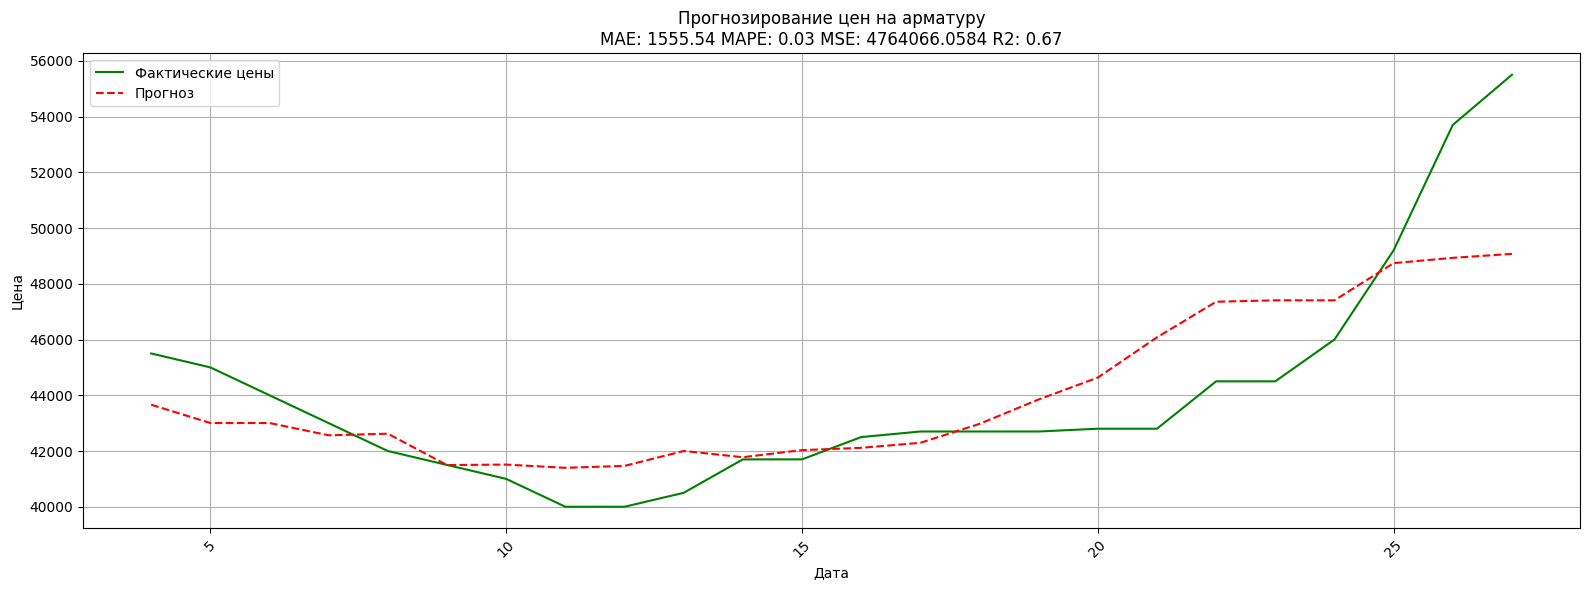

In [ ]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогнозирование цен на арматуру\nMAE: {mean_absolute_error(y_test, y_pred):.2f} MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f} MSE: {mean_squared_error(y_test, y_pred):.4f} R2: {r2_score(y_test, y_pred):.2f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_df_filtered.set_index('dt', inplace=True)
test_first_date = test_df['dt'][0]

x_train = train_df_filtered.loc[:test_first_date].drop('Цена на арматуру', axis=1)
y_train = train_df_filtered.loc[:test_first_date]['Цена на арматуру']
x_test = train_df_filtered.loc[test_first_date:].drop('Цена на арматуру', axis=1)
y_test = train_df_filtered.loc[test_first_date:]['Цена на арматуру']

MAE: 5065.86
RMSE: 6187.57
R2-score: -1.65


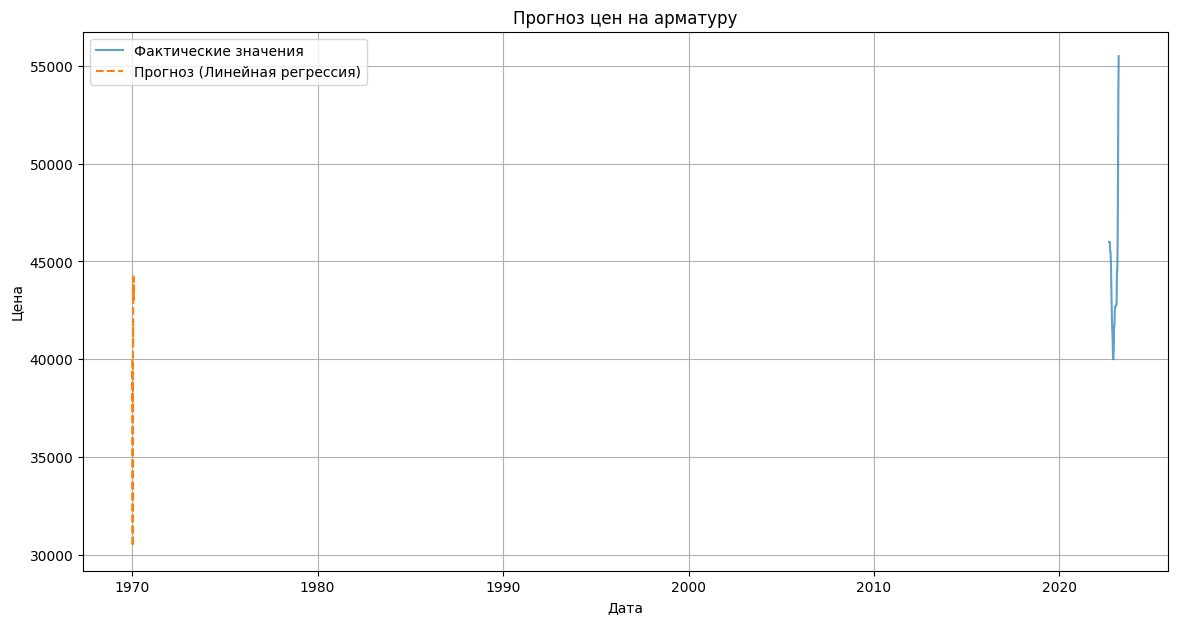

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# 9. Прогнозирование
predictions = model.predict(X_test)
predictions_series = pd.Series(predictions, index=y_test.index)

# 10. Оценка модели
print(f"MAE: {mean_absolute_error(y_test, predictions):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")
print(f"R2-score: {model.score(X_test, y_test):.2f}")

# 11. Визуализация
plt.figure(figsize=(14, 7))
# plt.plot(train_df_filtered.index, train_df_filtered['Цена на арматуру'], label='Обучающие данные')
plt.plot(test_df['dt'], test_df['Цена на арматуру'], label='Фактические значения', alpha=0.7)
plt.plot(predictions_series.index, predictions_series, label='Прогноз (Линейная регрессия)', linestyle='--')
plt.title('Прогноз цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()